# Find and load Sentinel 2 ARD Data using load_ard
This notebook uses the load_ard (load Analysis Ready Data) function to find and load Sentinel 2 data. The notebook also calulates the geomedian for the loaded data.



In [1]:
#What can be deleted here?
%matplotlib inline

import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import datacube
import fnmatch
import os
import pandas as pd
import geopandas as gpd

#get the DEA version of the plotting functions
import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb
#sys.path.append(os.path.abspath('/g/data/r78/DPIPWE_lm/repos/dea-notebooks/Scripts'))
#from dea_datahandling import load_ard
#import dea_plotting
#from dea_plotting import rgb
from datacube_stats.statistics import GeoMedian
from datacube.helpers import ga_pq_fuser
from datacube.utils import masking
from datacube.utils.cog import write_cog
from datacube.drivers.netcdf import write_dataset_to_netcdf
import xarray as xr

#Specify output directory
#outputdir = '/g/data/r78/DPIPWE_lm/output_data/'
outputdir = './'
if not os.path.exists(outputdir):
    print("output directory doesn't exist")
    exit()

/env/lib/python3.8/site-packages/datacube/storage/masking.py:7: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  warnings.warn("datacube.storage.masking has moved to datacube.utils.masking",


In [2]:
# Connect to datacube containing Sentinel 2 data
dc = datacube.Datacube(app='load_ard_and_geomedian')

In [3]:
# Create a reusable query (can change resolution and/or bands here if needed)
query = {
    'lat': (-40.188, -40.214),
    'lon': (148.228, 148.268),
    'time': ('2019-01', '2019-03'), # Months or day can be specified here
    'measurements': ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir_1'], # Can add nbart_swir2 for true flase colour but change res to 20
    'output_crs': 'EPSG:3577',
    'resolution': (-10, 10),
    'group_by': 'solar_day'
}

In [5]:
# Load available data from both Sentinel 2 satellites
ds = load_ard(dc=dc,
              products=['s2a_ard_granule', 's2b_ard_granule'],
              **query)

# Print output data
print(ds)

Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Applying pixel quality/cloud mask
Loading 18 time steps


CPLReleaseMutex: Error = 1 (Operation not permitted)


<xarray.Dataset>
Dimensions:      (time: 18, y: 327, x: 380)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-05T00:07:52.934000 ... 2019-03...
  * y            (y) float64 -4.484e+06 -4.484e+06 ... -4.487e+06 -4.487e+06
  * x            (x) float64 1.4e+06 1.4e+06 1.4e+06 ... 1.404e+06 1.404e+06
    spatial_ref  int32 3577
Data variables:
    nbart_blue   (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_green  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_red    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_nir_1  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


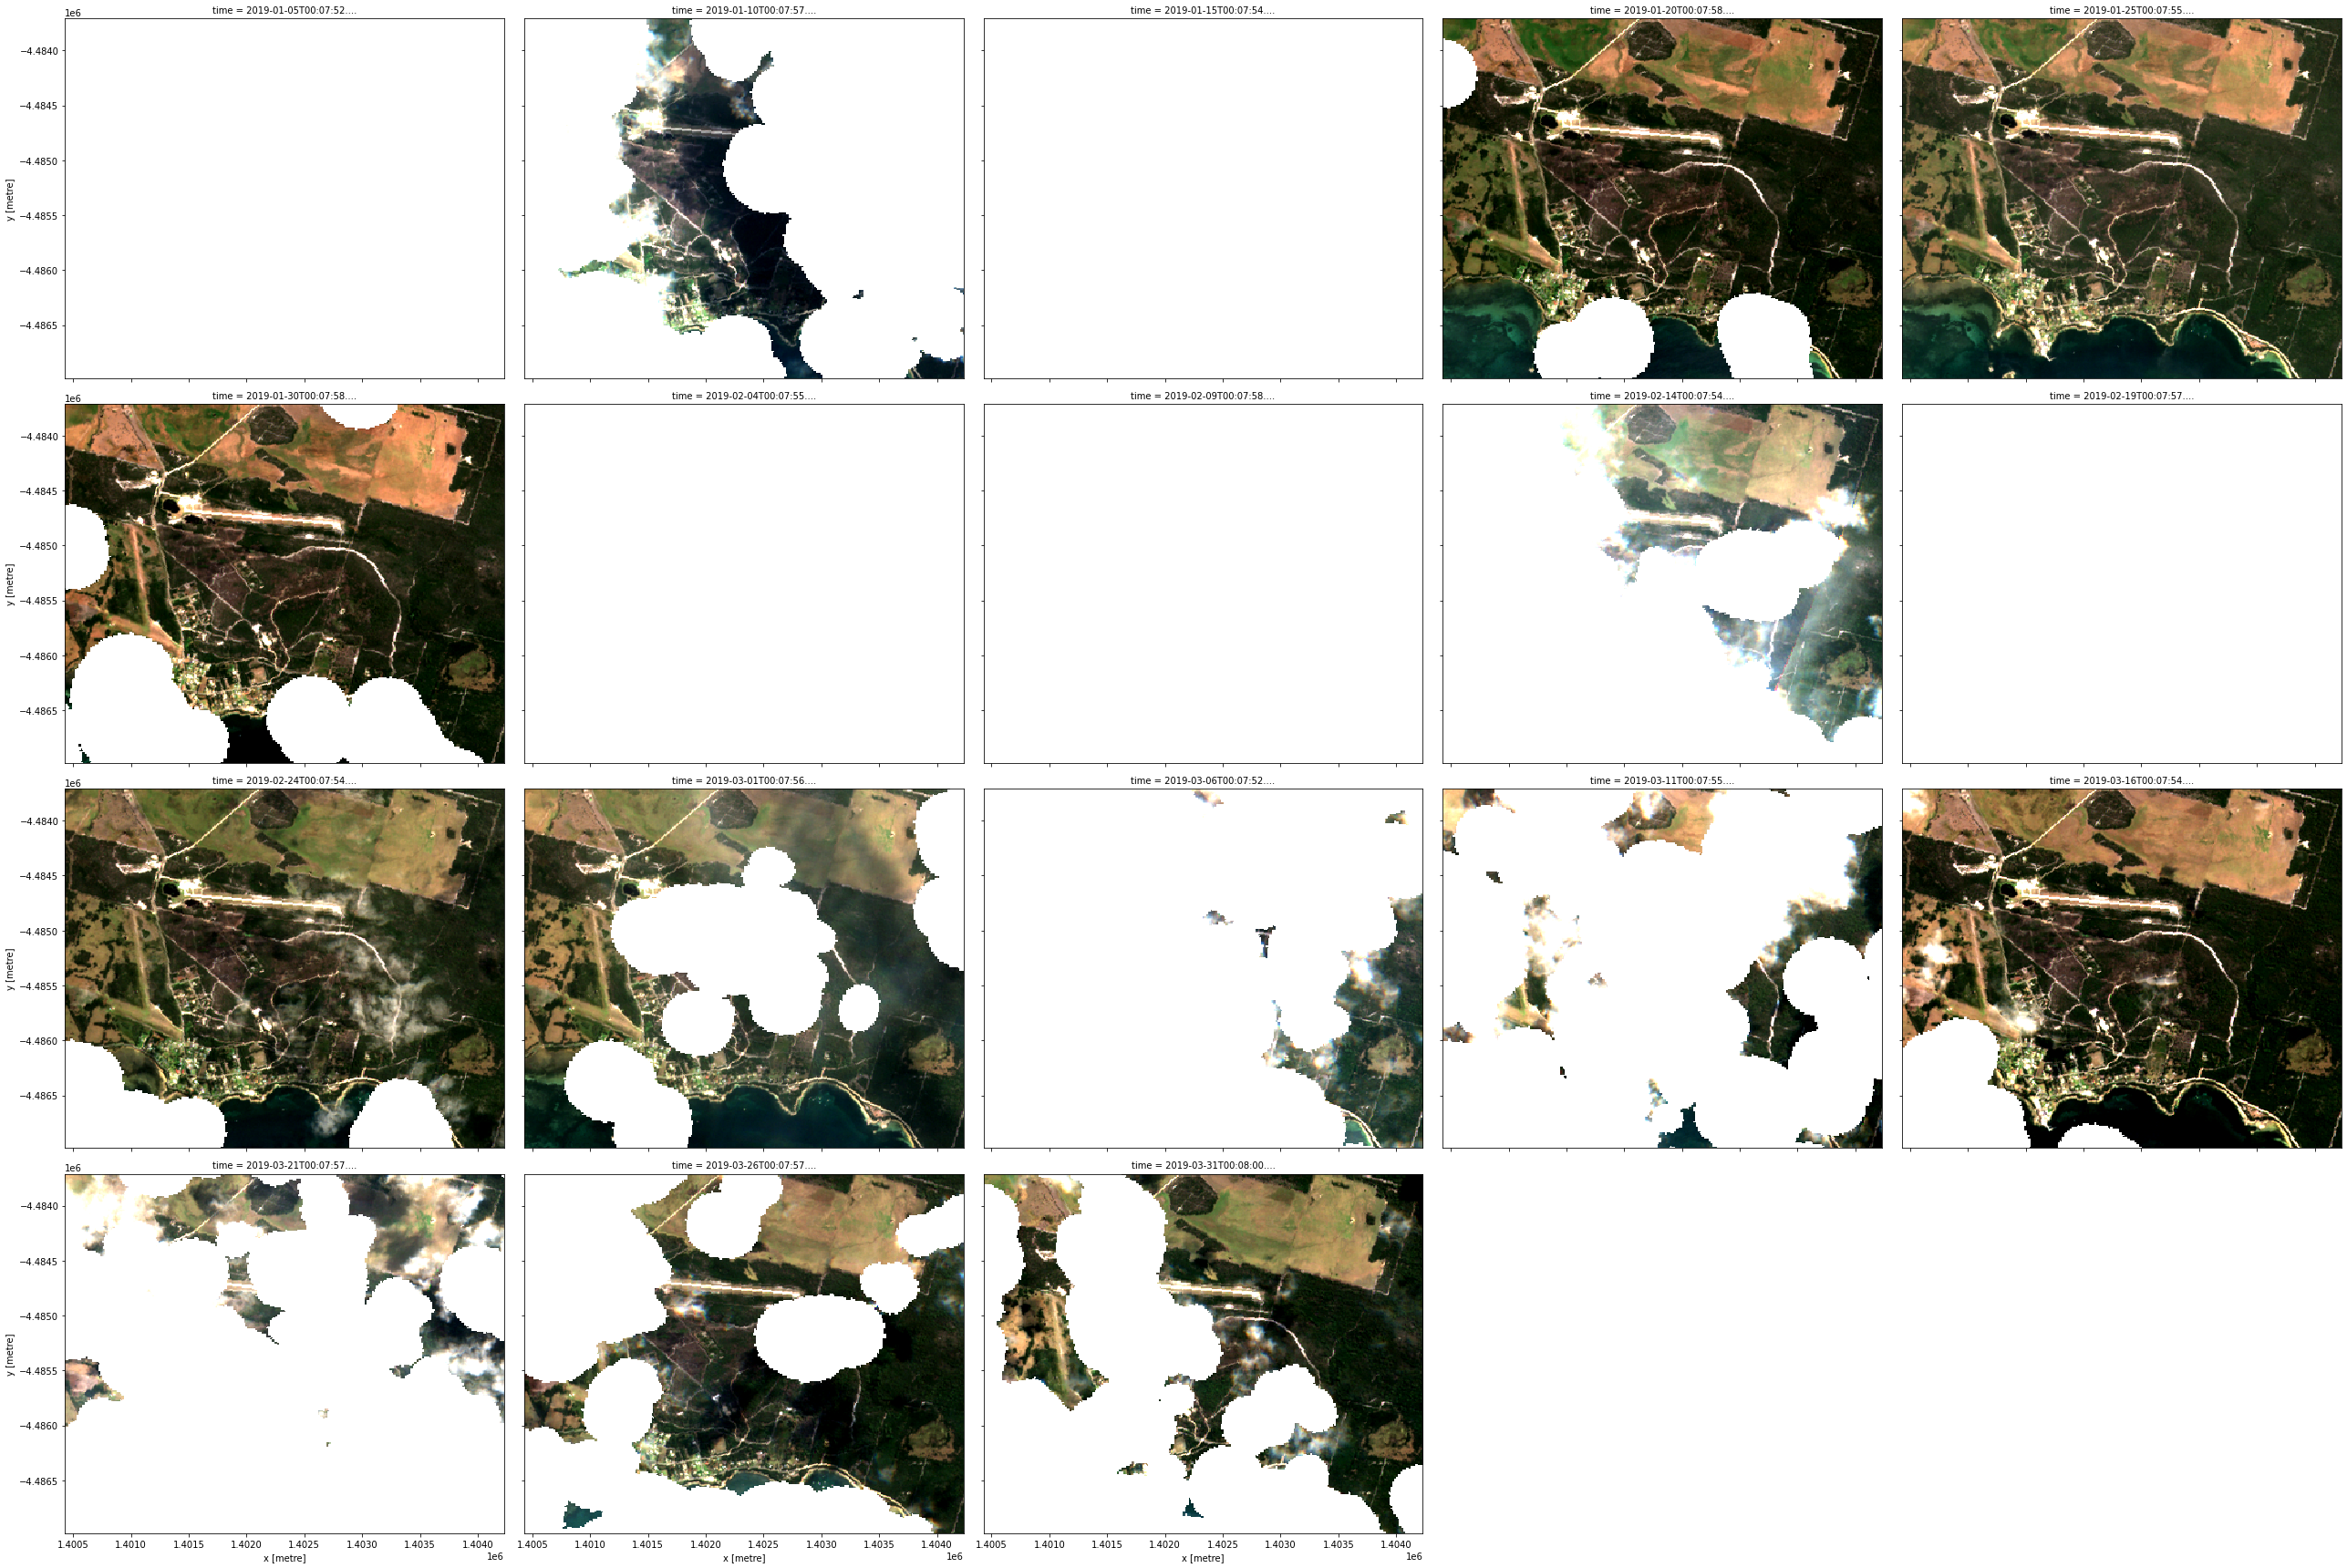

In [6]:
# Plot single observation
#ds.isel(time=6).nbart_nir_1.plot() # Plot time slice 6
#plt.show()

# This will plot all time slices so can take a while for large cubes
rgb(ds, percentile_stretch=(0.05, 0.95), col='time', col_wrap=5)

# Monthly Filter and Geomedian Creation

The cells below run through a process to filter the existing S2 datacube by month and then produce
a geomedian image. This type of process is useful where only dry season images are required e.g. for producing
dry season composite images (change month index as needed)

In [8]:
# function to return months of interest (cm = composite month)
def is_cm(month):
    return (month >= 11) | (month <= 4)

In [9]:
# extract just the months of interest
ds_cm = ds.sel(time=is_cm(ds['time.month']))

ds_cm['time.month'] #take a look at what months we have...

'''
Alternate method for extracting months via list
c_months = [11,12,1,2,3]
ds_cm = ds.sel(time=(ds['time.month'].isin(c_months)).dropna(dim='time'))
'''

"\nAlternate method for extracting months via list\nc_months = [11,12,1,2,3]\nds_cm = ds.sel(time=(ds['time.month'].isin(c_months)).dropna(dim='time'))\n"

In [10]:
ds_cm

<xarray.Dataset>
Dimensions:      (time: 18, y: 327, x: 380)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-05T00:07:52.934000 ... 2019-03...
  * y            (y) float64 -4.484e+06 -4.484e+06 ... -4.487e+06 -4.487e+06
  * x            (x) float64 1.4e+06 1.4e+06 1.4e+06 ... 1.404e+06 1.404e+06
    spatial_ref  int32 3577
Data variables:
    nbart_blue   (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_green  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_red    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_nir_1  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [11]:
# Compute geomedian here is necessary - either for dataset or subset months
ds_cm_gm = GeoMedian().compute(ds_cm)

# Put progress bar in here

Automatically using 16 threads.


In [12]:
ds_cm_gm

<xarray.Dataset>
Dimensions:      (y: 327, x: 380)
Coordinates:
  * y            (y) float64 -4.484e+06 -4.484e+06 ... -4.487e+06 -4.487e+06
  * x            (x) float64 1.4e+06 1.4e+06 1.4e+06 ... 1.404e+06 1.404e+06
    spatial_ref  int32 3577
Data variables:
    nbart_blue   (y, x) float32 590.0 608.0 603.0 595.7 ... 280.3 280.3 296.2
    nbart_green  (y, x) float32 848.0 851.0 862.0 829.3 ... 360.7 374.6 376.0
    nbart_red    (y, x) float32 1.014e+03 1.016e+03 1.029e+03 ... 298.6 308.1
    nbart_nir_1  (y, x) float32 3.033e+03 3.058e+03 ... 1.566e+03 1.534e+03

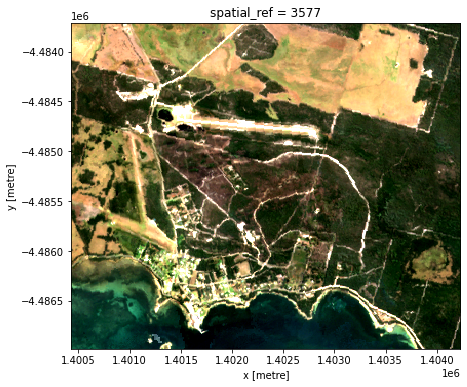

In [13]:
# Plot geomedian image
rgb(ds_cm_gm, percentile_stretch=(0.05, 0.95))

In [17]:
# Here we can export the geomedian
# for COG we need an array not a dataset
da = ds_cm_gm.to_array()

# Write multi-band GeoTIFF to a location
write_cog(geo_im=da,
          fname='Sent2_gomedian.tif',
          overwrite=True)

PosixPath('Sent2_gomedian.tif')